In [1]:
__author__ = 'Erwin Chen'
# interact with plot
# %matplotlib nbagg
# simply show plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import numpy as np
import scipy.stats as stats
import scipy.cluster.hierarchy as h
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
import pickle

In [2]:
# load data from fits file
hdulist = fits.open('allStar-v603.fits')
hdulist.info()
tbdata = hdulist[1].data
# APOGEE ID for stars
apogee_ID = tbdata.field('APOGEE_ID')
# Galactic Longitude
l = tbdata.field('GLON')
# Galactic Latitude 
b = tbdata.field('GLAT')
# Right Ascension(J2000)
RA = tbdata.field('RA')
# Declination(J2000)
DEC = tbdata.field('DEC')
# Heliocentric radial velocity
RV = tbdata.field('VHELIO_AVG')
J = tbdata.field('J')
H = tbdata.field('H')
K = tbdata.field('K')
LOGG = tbdata.field('LOGG')
TEFF = tbdata.field('TEFF')
# Proper Motion
PMRA = tbdata.field('PMRA')
PMDEC = tbdata.field('PMDEC')
# 15 elements
elements = np.array(["Al", "Ca", "C", "Fe", "K", "Mg", "Mn", "Na", "Ni", "N", "O", "Si", "S", "Ti", "V"])
AL_H = tbdata.field("AL_H")
CA_H = tbdata.field("CA_H")
C_H = tbdata.field("C_H")
FE_H = tbdata.field('FE_H')
K_H = tbdata.field("K_H")
MG_H = tbdata.field("MG_H")
MN_H = tbdata.field("MN_H")
NA_H = tbdata.field("NA_H")
NI_H = tbdata.field("NI_H")
N_H = tbdata.field("N_H")
O_H = tbdata.field("O_H")
SI_H = tbdata.field("SI_H")
S_H = tbdata.field("S_H")
TI_H = tbdata.field("TI_H")
V_H = tbdata.field("V_H")
# errors for 15 elements
AL_H_ERR = tbdata.field("AL_H_ERR")
CA_H_ERR = tbdata.field("CA_H_ERR")
C_H_ERR = tbdata.field("C_H_ERR")
FE_H_ERR = tbdata.field("FE_H_ERR")
K_H_ERR = tbdata.field("K_H_ERR")
MG_H_ERR = tbdata.field("MG_H_ERR")
MN_H_ERR = tbdata.field("MN_H_ERR")
NA_H_ERR = tbdata.field("NA_H_ERR")
NI_H_ERR = tbdata.field("NI_H_ERR")
N_H_ERR = tbdata.field("N_H_ERR")
O_H_ERR = tbdata.field("O_H_ERR")
SI_H_ERR = tbdata.field("SI_H_ERR")
S_H_ERR = tbdata.field("S_H_ERR")
TI_H_ERR = tbdata.field("TI_H_ERR")
V_H_ERR = tbdata.field("V_H_ERR")

Filename: allStar-v603.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      15   ()              
1                BinTableHDU    324   163278R x 151C   [45A, 34A, 44A, 34A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, 2E, 2E, 2E, 5A, 6A, 4A, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, 18A, 12A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, E, E, I, I, E, E, 20A, 737A, 665A, 50J, 50J]   
2                ImageHDU         6   (360,)       int32   
3                BinTableHDU     31   1R x 4C      [105A, 30A, 90A, 15I]   


In [3]:
# get chemical abundances of 15 elements for all available stars
def get_matrix_all():
    # get stars with valid info
    C = np.where(
        (LOGG > -9999.) * (TEFF > -9999.) * (RV < 999999.0) *
        (AL_H > -9999.) * (CA_H > -9999.) * (C_H > -9999.0) *
        (FE_H > -9999.) * (K_H > -9999.0) * (MG_H > - 9999.0) *
        (MN_H > -9999.) * (NA_H > -9999.0) * (NI_H > -9999.) *
        (N_H > -9999.) * (O_H > -9999.0) * (SI_H > -9999.) *
        (S_H > -9999.) * (TI_H > -9999.) * (V_H > -9999.))[0]
    data = []
    data.append(C_H[C])
    data.append(FE_H[C])
    data.append(N_H[C])
    data.append(O_H[C])
    data.append(MG_H[C])
    data.append(SI_H[C])
    data.append(NI_H[C])
    data.append(AL_H[C])
    data.append(CA_H[C])
    data.append(MN_H[C])
    data.append(NA_H[C])
    data.append(S_H[C])
    data.append(K_H[C])
    data.append(TI_H[C])
    data.append(V_H[C])
    data = np.array(data)
    data = data.T
    return data

# get chemical abundances of 15 elements for selected stars
def get_matrix(C):
    data = []
    data.append(C_H[C])
    data.append(FE_H[C])
    data.append(N_H[C])
    data.append(O_H[C])
    data.append(MG_H[C])
    data.append(SI_H[C])
    data.append(NI_H[C])
    data.append(AL_H[C])
    data.append(CA_H[C])
    data.append(MN_H[C])
    data.append(NA_H[C])
    data.append(S_H[C])
    data.append(K_H[C])
    data.append(TI_H[C])
    data.append(V_H[C])
    data = np.array(data)
    data = data.T
    return data

def get_matrix_all_normalized():
    # get stars with valid info
    C = np.where(
        (LOGG > -9999.) * (TEFF > -9999.) * (RV < 999999.0) *
        (AL_H > -9999.) * (CA_H > -9999.) * (C_H > -9999.0) *
        (FE_H > -9999.) * (K_H > -9999.0) * (MG_H > - 9999.0) *
        (MN_H > -9999.) * (NA_H > -9999.0) * (NI_H > -9999.) *
        (N_H > -9999.) * (O_H > -9999.0) * (SI_H > -9999.) *
        (S_H > -9999.) * (TI_H > -9999.) * (V_H > -9999.))[0]
    data = []
    data.append(C_H[C] / np.mean(C_H_ERR[C]))
    data.append(FE_H[C] / np.mean(FE_H_ERR[C]))
    data.append(N_H[C] / np.mean(N_H_ERR[C]))
    data.append(O_H[C] / np.mean(O_H_ERR[C]))
    data.append(MG_H[C] / np.mean(MG_H_ERR[C]))
    data.append(SI_H[C] / np.mean(SI_H_ERR[C]))
    data.append(NI_H[C] / np.mean(NI_H_ERR[C]))
    data.append(AL_H[C] / np.mean(AL_H_ERR[C]))
    data.append(CA_H[C] / np.mean(CA_H_ERR[C]))
    data.append(MN_H[C] / np.mean(MN_H_ERR[C]))
    data.append(NA_H[C] / np.mean(NA_H_ERR[C]))
    data.append(S_H[C] / np.mean(S_H_ERR[C]))
    data.append(K_H[C] / np.mean(K_H_ERR[C]))
    data.append(TI_H[C] / np.mean(TI_H_ERR[C]))
    data.append(V_H[C] / np.mean(V_H_ERR[C]))
    data = np.array(data)
    data = data.T
    return data

def get_matrix_normalized(C):
    data = []
    data.append(C_H[C] / np.mean(C_H_ERR[C]))
    data.append(FE_H[C] / np.mean(FE_H_ERR[C]))
    data.append(N_H[C] / np.mean(N_H_ERR[C]))
    data.append(O_H[C] / np.mean(O_H_ERR[C]))
    data.append(MG_H[C] / np.mean(MG_H_ERR[C]))
    data.append(SI_H[C] / np.mean(SI_H_ERR[C]))
    data.append(NI_H[C] / np.mean(NI_H_ERR[C]))
    data.append(AL_H[C] / np.mean(AL_H_ERR[C]))
    data.append(CA_H[C] / np.mean(CA_H_ERR[C]))
    data.append(MN_H[C] / np.mean(MN_H_ERR[C]))
    data.append(NA_H[C] / np.mean(NA_H_ERR[C]))
    data.append(S_H[C] / np.mean(S_H_ERR[C]))
    data.append(K_H[C] / np.mean(K_H_ERR[C]))
    data.append(TI_H[C] / np.mean(TI_H_ERR[C]))
    data.append(V_H[C] / np.mean(V_H_ERR[C]))
    data = np.array(data)
    data = data.T
    return data



In [4]:
all_stars = np.where(
        (LOGG > -9999.) * (TEFF > -9999.) * (RV < 999999.0) *
        (AL_H > -9999.) * (CA_H > -9999.) * (C_H > -9999.0) *
        (FE_H > -9999.) * (K_H > -9999.0) * (MG_H > - 9999.0) *
        (MN_H > -9999.) * (NA_H > -9999.0) * (NI_H > -9999.) *
        (N_H > -9999.) * (O_H > -9999.0) * (SI_H > -9999.) *
        (S_H > -9999.) * (TI_H > -9999.) * (V_H > -9999.))[0]
# divide stars into groups based on their location
llbb = []
llbb.append(l[all_stars])
llbb.append(b[all_stars])
llbb = np.array(llbb).T
db = DBSCAN(eps=2, min_samples=50).fit(llbb)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_llbb = db.labels_

In [5]:
# chemical tagging with DBSCAN in each location group
poss_members = []
for n in range(labels_llbb.max()):
    # certain location of the sky
    if np.where(labels_llbb == n)[0].size > 100:
        # perform chemical tagging for the location
        stars = all_stars[np.where(labels_llbb == n)[0]]
        data = get_matrix_normalized(stars)
        kmeans = KMeans(n_clusters=stars.size/100, n_init=10)
        kmeans.fit(data)
        labels = kmeans.labels_
        # choose one of the following two
# 1 -----------------------------------------------------------------------------------------
#         # find the group with the least dispersion in chemical space
#         if labels.max() > -1:
#             chem_disp = []
#             for m in range(-1, labels.max()+1):
#                 group = stars[np.where(labels == m)[0]]
#                 chem_disp.append(np.std(FE_H[group]))
#             chem_disp = np.array(chem_disp)
#             # print chem_disp
#             index = np.argsort(chem_disp)[0]
#             poss_members.append(stars[np.where(labels == index)[0]])
# 2 ------------------------------------------------------------------------------------------
        # append every group that is not considered background
        for index in range(labels.max()+1):
            poss_members.append(stars[np.where(labels == index)[0]])
#------------------------------------------------------------------------------------------
poss_members = np.array(poss_members) 
print poss_members.size

724


In [6]:
# compare the possible members 
# load known members
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
# names of all known clusters
known_clusters_names = known_clusters[1]
# M92, M15, M53, N5466, M2, M13, M3, M5, M107, M71, N2158, N2420, N188, M67, Pleiades, N6819, N6791
# APOGEE IDs for all known members
known_clusters_ID = known_clusters[0]
# get all known members
members = np.array([np.where(ID == apogee_ID)[0][0] for ID in known_clusters_ID])
# get members with all 15 elements
members_15 = np.intersect1d(all_stars, members)
# list of names of clusters to check
clusters_names = np.array(["M107", "M13", "M5", "N6819", "M67"])
for name in clusters_names:
    # get members of a known cluster
    name_members_ID = known_clusters_ID[np.where(name == known_clusters_names)]
    name_members = np.array([np.where(ID == apogee_ID)[0][0] for ID in name_members_ID])
    name_members = np.intersect1d(name_members, members_15)
    for group in poss_members:
        overlap = np.intersect1d(name_members, group)
        if overlap.size > 0:
            print name, group.size, overlap.size

M107 47 4
M107 97 10
M107 114 1
M13 64 20
M5 103 43
N6819 257 4
N6819 238 6
N6819 222 1
N6819 74 1
N6819 224 2
N6819 215 2
N6819 204 1
N6819 111 3
N6819 274 5
N6819 213 1
N6819 244 3
M67 173 24


In [10]:
# the relationship between actual clusters and location groups
for name in clusters_names:
    # get members of a known cluster
    name_members_ID = known_clusters_ID[np.where(name == known_clusters_names)]
    name_members = np.array([np.where(ID == apogee_ID)[0][0] for ID in name_members_ID])
    name_members = np.intersect1d(name_members, members_15)
    for n in range(labels_llbb.max()+1):
        group = all_stars[np.where(labels_llbb == n)[0]]
        if np.intersect1d(group, name_members).size > 0:
            print name, n, group.size, name_members.size, np.intersect1d(group, name_members).size

M107 115 673 15 15
M13 117 264 20 20
M5 107 294 43 43
N6819 135 7471 29 29
M67 48 173 24 24


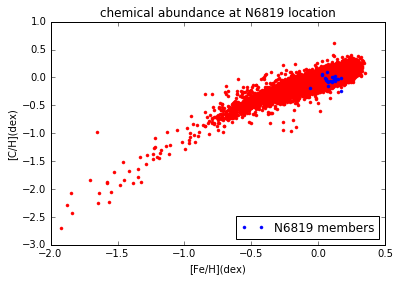

In [11]:
# plot Fe-C of the location group where N6819 is located
N6819_members_ID = known_clusters_ID[np.where("N6819" == known_clusters_names)]
N6819_members = np.array([np.where(ID == apogee_ID)[0][0] for ID in name_members_ID])
N6819_members = np.intersect1d(name_members, members_15)
N6819_llbb = all_stars[np.where(labels_llbb == 135)[0]]
plt.plot(FE_H[N6819_llbb], C_H[N6819_llbb], "r.")
plt.plot(FE_H[N6819_members], C_H[N6819_members], "b.", label="N6819 members")
plt.title("chemical abundance at N6819 location")
plt.xlabel("[Fe/H](dex)")
plt.ylabel("[C/H](dex)")
plt.legend(loc=4)
plt.show()

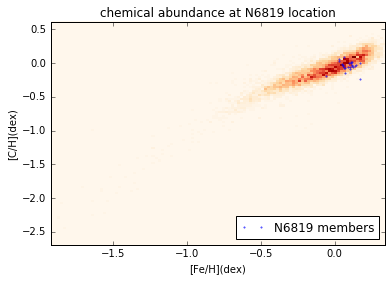

In [12]:
plt.hist2d(FE_H[N6819_llbb], C_H[N6819_llbb], bins=110, cmap="OrRd")
plt.plot(FE_H[N6819_members], C_H[N6819_members], "b.", label="N6819 members", alpha=0.6, markersize=3)
plt.title("chemical abundance at N6819 location")
plt.xlabel("[Fe/H](dex)")
plt.ylabel("[C/H](dex)")
plt.legend(loc=4)
plt.show()